In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch

from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

2024-05-28 08:22:16.989044: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 08:22:17.025232: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 08:22:17.025250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 08:22:17.026094: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-28 08:22:17.031971: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)

CUDA is available. Using GPU.
Tensor is on device: cuda:0


## Example Pinball loss / Quantile loss

In [3]:
tau=0.1
y_hat=3
y=np.linspace(y_hat-10,y_hat+10,100)

# Calculate loss
loss=(1-tau)*(np.abs(y-y_hat))
y_larger=y>y_hat
loss[y_larger]=tau*(np.abs(y[y_larger]-y_hat))

In [4]:
loss=(1-tau)*(np.abs(y-y_hat))
y_larger=y>y_hat

loss[y_larger]=tau*(np.abs(y[y_larger]-y_hat))

In [5]:
tau=0.1
y_hat=3
u=np.linspace(-100,100,1000)
u_ints=np.unique(np.ceil(u))
u_ticks=u_ints[np.nonzero((u_ints%2)==0)]

def plot_function(tau):
    
    loss=(1-tau)*(np.abs(u))
    y_larger=u<0
    loss[y_larger]=tau*(np.abs(u[y_larger]))

    plt.plot(u,loss)
    plt.rcParams["figure.figsize"] = [10, 5]
    plt.grid()
    plt.xticks(u_ticks)
    plt.xlim([-10,10])
    plt.ylim([-1,8])
    plt.legend([r'$\mathcal{L}(y_{\tau},y)$',r'$y_{\tau}$'])
    plt.xlabel(r"$u=y_{\tau}-y$")
    plt.ylabel(r'$\mathcal{L}$')
    plt.title(r'Example of the Quantile loss / Pinball loss function')
    plt.show()
    
interact(plot_function, tau = widgets.FloatSlider(value=0.1,
                                               min=0.0,
                                               max=1.0,
                                               step=0.01))

interactive(children=(FloatSlider(value=0.1, description='tau', max=1.0, step=0.01), Output()), _dom_classes=(…

<function __main__.plot_function(tau)>

## Plot for report

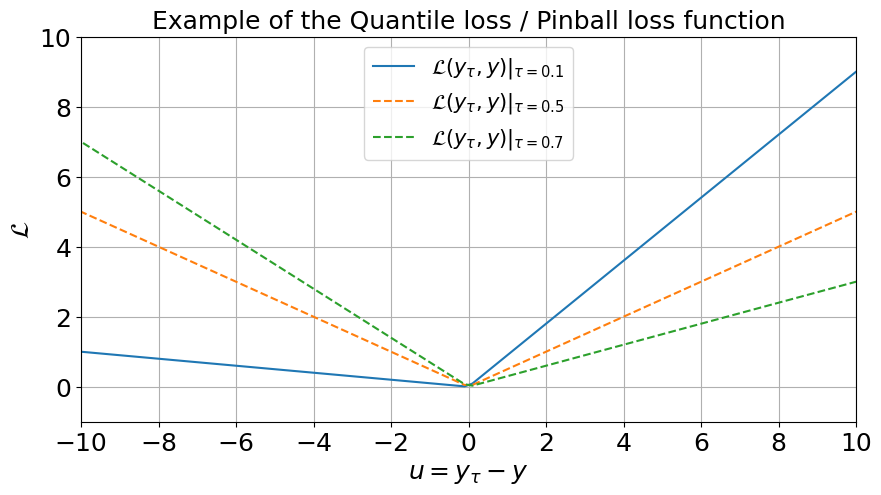

In [6]:
tau=0.1
u=np.linspace(-100,100,1000)
u_ints=np.unique(np.ceil(u))
u_ticks=u_ints[np.nonzero((u_ints%2)==0)]    

loss=(1-tau)*(np.abs(u))
y_larger=u<0
loss[y_larger]=tau*(np.abs(u[y_larger]))

tau_2=0.5
loss_2=(1-tau_2)*(np.abs(u))
loss_2[y_larger]=tau_2*(np.abs(u[y_larger]))

tau_3=0.7
loss_3=(1-tau_3)*(np.abs(u))
loss_3[y_larger]=tau_3*(np.abs(u[y_larger]))

fontsize=18

plt.plot(u,loss)
plt.plot(u,loss_2,'--')
plt.plot(u,loss_3,'--')
plt.rcParams["figure.figsize"] = [10, 5]
plt.grid()
plt.xticks(u_ticks,fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlim([-10,10])
plt.ylim([-1,10])
plt.legend([r'$\mathcal{L}(y_{\tau},y)|_{\tau =0.1}$',r'$\mathcal{L}(y_{\tau},y)|_{\tau =0.5}$',r'$\mathcal{L}(y_{\tau},y)|_{\tau =0.7}$'],fontsize=fontsize-3)
plt.xlabel(r"$u=y_{\tau}-y$",fontsize=fontsize)
plt.ylabel(r'$\mathcal{L}$',fontsize=fontsize)
plt.title(r'Example of the Quantile loss / Pinball loss function',fontsize=fontsize)
plt.show()

## Example Quantile Regression Neural Networks (QRNN)

In [7]:
def draw_sample_sin(n_samps, sigma):
    x=np.random.uniform(low=0,high=2*np.pi,size=n_samps)
    noise=np.random.normal(loc=0,scale=sigma,size=n_samps)
    y=np.sin(x)+noise
    return x,y

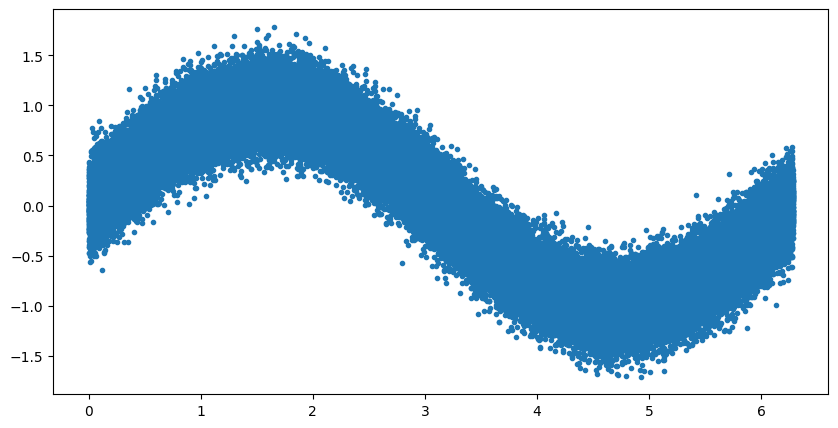

In [8]:
x,y = draw_sample_sin(100000,0.2)
plt.plot(x,y,'.')

In [9]:
x=np.array([x]).T
X_train, X_test, y_train, y_test=train_test_split(x,y,test_size=0.05)


import random

val_size=0.05
validation_indices=np.array(random.sample(range(len(X_train)), int(len(X_train)*val_size)))
train_indices=[i for i in range(len(X_train)) if np.any(validation_indices==i)==False]

quantiles=np.array([0.1,0.5,0.9])
batch_size=500


In [15]:
nepochs=200
quantiles=np.array([0.025,0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95,0.975])
quantiles_01=np.array([0,0.025,0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95,0.975,1])

model=QuantileNetwork(quantiles=quantiles)

# Add everything but the output layer
sequence=nn.Sequential(
    nn.Linear(1,64),
    nn.ReLU(),
    nn.Linear(64, len(quantiles)*1) #Output dimesion is number of quantiles times number of target variables
)
model.fit(X_train,y_train, 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence)

Epoch 1


/home/edgelab/.local/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
Batch number:  36%|███▌      | 65/181 [00:00<00:00, 647.68it/s]

Batch number: 100%|██████████| 181/181 [00:00<00:00, 594.60it/s]

Training loss [3.6811543] Validation loss [1.3244753]
----New best validation loss---- [1.3244753]
Epoch 2



Batch number: 100%|██████████| 181/181 [00:00<00:00, 567.55it/s]

Training loss [1.191105] Validation loss [1.0661036]
----New best validation loss---- [1.0661036]
Epoch 3



Batch number: 100%|██████████| 181/181 [00:00<00:00, 610.49it/s]


Training loss [0.97006404] Validation loss [0.8670449]
----New best validation loss---- [0.8670449]
Epoch 4


Batch number: 100%|██████████| 181/181 [00:00<00:00, 625.66it/s]

Training loss [0.8070715] Validation loss [0.76608664]
----New best validation loss---- [0.76608664]
Epoch 5



Batch number: 100%|██████████| 181/181 [00:00<00:00, 604.60it/s]


Training loss [0.74472576] Validation loss [0.73023325]
----New best validation loss---- [0.73023325]
Epoch 6


Batch number: 100%|██████████| 181/181 [00:00<00:00, 571.79it/s]

Training loss [0.7181005] Validation loss [0.71269786]
----New best validation loss---- [0.71269786]
Epoch 7



Batch number: 100%|██████████| 181/181 [00:00<00:00, 595.39it/s]

Training loss [0.7012513] Validation loss [0.69539833]
----New best validation loss---- [0.69539833]
Epoch 8



Batch number: 100%|██████████| 181/181 [00:00<00:00, 631.48it/s]

Training loss [0.6892611] Validation loss [0.68662]
----New best validation loss---- [0.68662]
Epoch 9



Batch number: 100%|██████████| 181/181 [00:00<00:00, 601.87it/s]


Training loss [0.6808269] Validation loss [0.68238366]
----New best validation loss---- [0.68238366]
Epoch 10


Batch number: 100%|██████████| 181/181 [00:00<00:00, 575.99it/s]

Training loss [0.6772365] Validation loss [0.67373496]
----New best validation loss---- [0.67373496]
Epoch 11



Batch number: 100%|██████████| 181/181 [00:00<00:00, 590.38it/s]

Training loss [0.672408] Validation loss [0.6769464]
Epoch 12



Batch number: 100%|██████████| 181/181 [00:00<00:00, 621.10it/s]

Training loss [0.6676744] Validation loss [0.67914236]
Epoch 13



Batch number: 100%|██████████| 181/181 [00:00<00:00, 575.20it/s]

Training loss [0.66695255] Validation loss [0.66782236]
----New best validation loss---- [0.66782236]
Epoch 14



Batch number: 100%|██████████| 181/181 [00:00<00:00, 604.77it/s]


Training loss [0.66552395] Validation loss [0.6718066]
Epoch 15


Batch number: 100%|██████████| 181/181 [00:00<00:00, 572.44it/s]

Training loss [0.663945] Validation loss [0.6690813]
Epoch 16



Batch number: 100%|██████████| 181/181 [00:00<00:00, 574.26it/s]

Training loss [0.6624597] Validation loss [0.65973437]
----New best validation loss---- [0.65973437]
Epoch 17



Batch number: 100%|██████████| 181/181 [00:00<00:00, 574.93it/s]

Training loss [0.66109234] Validation loss [0.6679692]
Epoch 18



Batch number: 100%|██████████| 181/181 [00:00<00:00, 571.69it/s]

Training loss [0.661881] Validation loss [0.6673949]
Epoch 19



Batch number: 100%|██████████| 181/181 [00:00<00:00, 578.14it/s]

Training loss [0.65945] Validation loss [0.6554536]
----New best validation loss---- [0.6554536]
Epoch 20



Batch number: 100%|██████████| 181/181 [00:00<00:00, 574.84it/s]

Training loss [0.65952957] Validation loss [0.6612199]
Epoch 21



Batch number: 100%|██████████| 181/181 [00:00<00:00, 575.27it/s]

Training loss [0.6571535] Validation loss [0.6602081]
Epoch 22



Batch number: 100%|██████████| 181/181 [00:00<00:00, 579.16it/s]

Training loss [0.65826064] Validation loss [0.6588856]
Epoch 23



Batch number: 100%|██████████| 181/181 [00:00<00:00, 598.35it/s]

Training loss [0.6573326] Validation loss [0.656837]
Epoch 24



Batch number: 100%|██████████| 181/181 [00:00<00:00, 587.72it/s]

Training loss [0.6592899] Validation loss [0.6641448]
Epoch 25



Batch number: 100%|██████████| 181/181 [00:00<00:00, 600.57it/s]


Training loss [0.65754545] Validation loss [0.6552056]
----New best validation loss---- [0.6552056]
Epoch 26


Batch number: 100%|██████████| 181/181 [00:00<00:00, 579.59it/s]

Training loss [0.65502614] Validation loss [0.6492721]
----New best validation loss---- [0.6492721]
Epoch 27



Batch number: 100%|██████████| 181/181 [00:00<00:00, 602.45it/s]

Training loss [0.65823585] Validation loss [0.66040224]
Epoch 28



Batch number: 100%|██████████| 181/181 [00:00<00:00, 579.57it/s]

Training loss [0.65629095] Validation loss [0.6597916]
Epoch 29



Batch number: 100%|██████████| 181/181 [00:00<00:00, 601.00it/s]


Training loss [0.65640247] Validation loss [0.6596389]
Epoch 30


Batch number: 100%|██████████| 181/181 [00:00<00:00, 576.48it/s]

Training loss [0.65484065] Validation loss [0.6552424]
Epoch 31



Batch number: 100%|██████████| 181/181 [00:00<00:00, 576.91it/s]

Training loss [0.6548095] Validation loss [0.6598307]
Epoch 32



Batch number: 100%|██████████| 181/181 [00:00<00:00, 576.07it/s]

Training loss [0.6546111] Validation loss [0.6593348]
Epoch 33



Batch number: 100%|██████████| 181/181 [00:00<00:00, 577.40it/s]

Training loss [0.6555858] Validation loss [0.65641636]
Epoch 34



Batch number: 100%|██████████| 181/181 [00:00<00:00, 573.74it/s]

Training loss [0.65503985] Validation loss [0.6495164]
Epoch 35



Batch number: 100%|██████████| 181/181 [00:00<00:00, 574.23it/s]

Training loss [0.65488136] Validation loss [0.650689]
Epoch 36



Batch number: 100%|██████████| 181/181 [00:00<00:00, 570.99it/s]

Training loss [0.6541411] Validation loss [0.64908713]
----New best validation loss---- [0.64908713]
Epoch 37



Batch number: 100%|██████████| 181/181 [00:00<00:00, 576.36it/s]

Training loss [0.65491307] Validation loss [0.655271]
Epoch 38



Batch number: 100%|██████████| 181/181 [00:00<00:00, 574.36it/s]

Training loss [0.654908] Validation loss [0.657672]
Epoch 39



Batch number: 100%|██████████| 181/181 [00:00<00:00, 571.07it/s]

Training loss [0.6542155] Validation loss [0.65174395]
Epoch 40



Batch number: 100%|██████████| 181/181 [00:00<00:00, 576.20it/s]

Training loss [0.65350336] Validation loss [0.6519849]
Epoch 41



Batch number: 100%|██████████| 181/181 [00:00<00:00, 577.16it/s]

Training loss [0.653815] Validation loss [0.6579719]
Epoch 42



Batch number: 100%|██████████| 181/181 [00:00<00:00, 570.84it/s]

Training loss [0.6549307] Validation loss [0.65693766]
Epoch 43



Batch number: 100%|██████████| 181/181 [00:00<00:00, 574.04it/s]

Training loss [0.6541151] Validation loss [0.6549209]
Epoch 44



Batch number: 100%|██████████| 181/181 [00:00<00:00, 573.58it/s]

Training loss [0.6528996] Validation loss [0.65389246]
Epoch 45



Batch number: 100%|██████████| 181/181 [00:00<00:00, 576.33it/s]

Training loss [0.6553371] Validation loss [0.6540613]
Epoch 46



Batch number: 100%|██████████| 181/181 [00:00<00:00, 575.39it/s]

Training loss [0.65318525] Validation loss [0.6565724]
Epoch 47



Batch number: 100%|██████████| 181/181 [00:00<00:00, 575.56it/s]

Training loss [0.65395755] Validation loss [0.65259933]
Epoch 48



Batch number: 100%|██████████| 181/181 [00:00<00:00, 575.85it/s]

Training loss [0.6535236] Validation loss [0.66005313]
Epoch 49



Batch number: 100%|██████████| 181/181 [00:00<00:00, 576.88it/s]

Training loss [0.6537635] Validation loss [0.6508344]
Epoch 50



Batch number: 100%|██████████| 181/181 [00:00<00:00, 603.51it/s]


Training loss [0.6536771] Validation loss [0.65306765]
Epoch 51


Batch number: 100%|██████████| 181/181 [00:00<00:00, 571.73it/s]

Training loss [0.6526619] Validation loss [0.65478534]
Epoch 52



Batch number: 100%|██████████| 181/181 [00:00<00:00, 570.34it/s]

Training loss [0.653281] Validation loss [0.6537802]
Epoch 53



Batch number: 100%|██████████| 181/181 [00:00<00:00, 590.85it/s]

Training loss [0.6537306] Validation loss [0.65828705]
Epoch 54



Batch number: 100%|██████████| 181/181 [00:00<00:00, 574.45it/s]

Training loss [0.655473] Validation loss [0.6513842]
Epoch 55



Batch number: 100%|██████████| 181/181 [00:00<00:00, 652.79it/s]

Training loss [0.65295535] Validation loss [0.6561784]
Epoch 56



Batch number: 100%|██████████| 181/181 [00:00<00:00, 553.53it/s]

Training loss [0.65277874] Validation loss [0.6556821]
Epoch 57



Batch number: 100%|██████████| 181/181 [00:00<00:00, 569.79it/s]

Training loss [0.65394795] Validation loss [0.6576316]
Epoch 58



Batch number: 100%|██████████| 181/181 [00:00<00:00, 655.31it/s]

Training loss [0.65608245] Validation loss [0.6595152]
Epoch 59



Batch number: 100%|██████████| 181/181 [00:00<00:00, 576.20it/s]

Training loss [0.65274304] Validation loss [0.6641336]
Epoch 60



Batch number: 100%|██████████| 181/181 [00:00<00:00, 624.08it/s]

Training loss [0.6538479] Validation loss [0.6566514]
Epoch 61



Batch number: 100%|██████████| 181/181 [00:00<00:00, 575.17it/s]

Training loss [0.65487736] Validation loss [0.65771466]
Epoch 62



Batch number: 100%|██████████| 181/181 [00:00<00:00, 576.04it/s]

Training loss [0.65486354] Validation loss [0.65139437]
Epoch 63



Batch number: 100%|██████████| 181/181 [00:00<00:00, 593.90it/s]

Training loss [0.6534119] Validation loss [0.6639729]
Epoch 64



Batch number: 100%|██████████| 181/181 [00:00<00:00, 591.78it/s]

Training loss [0.65354794] Validation loss [0.65581197]
Epoch 65



Batch number: 100%|██████████| 181/181 [00:00<00:00, 571.64it/s]

Training loss [0.6537011] Validation loss [0.6542558]
Epoch 66



Batch number: 100%|██████████| 181/181 [00:00<00:00, 606.83it/s]


Training loss [0.6553368] Validation loss [0.65398747]
Epoch 67


Batch number: 100%|██████████| 181/181 [00:00<00:00, 577.11it/s]

Training loss [0.65496033] Validation loss [0.65467495]
Epoch 68



Batch number: 100%|██████████| 181/181 [00:00<00:00, 573.94it/s]

Training loss [0.65266484] Validation loss [0.6549384]
Epoch 69



Batch number: 100%|██████████| 181/181 [00:00<00:00, 577.27it/s]

Training loss [0.65567374] Validation loss [0.65230924]
Epoch 70



Batch number: 100%|██████████| 181/181 [00:00<00:00, 576.81it/s]

Training loss [0.65473044] Validation loss [0.6577396]
Epoch 71



Batch number: 100%|██████████| 181/181 [00:00<00:00, 605.04it/s]


Training loss [0.6530195] Validation loss [0.652]
Epoch 72


Batch number: 100%|██████████| 181/181 [00:00<00:00, 606.84it/s]


Training loss [0.6549436] Validation loss [0.6538779]
Epoch 73


Batch number: 100%|██████████| 181/181 [00:00<00:00, 575.70it/s]

Training loss [0.6539057] Validation loss [0.65063804]
Epoch 74



Batch number: 100%|██████████| 181/181 [00:00<00:00, 603.35it/s]


Training loss [0.6540018] Validation loss [0.6563506]
Epoch 75


Batch number: 100%|██████████| 181/181 [00:00<00:00, 590.24it/s]

Training loss [0.6531316] Validation loss [0.65564495]
Epoch 76



Batch number: 100%|██████████| 181/181 [00:00<00:00, 583.49it/s]

Training loss [0.6545629] Validation loss [0.65374124]
Epoch 77



Batch number: 100%|██████████| 181/181 [00:00<00:00, 678.87it/s]

Training loss [0.65257776] Validation loss [0.65728045]
Epoch 78



Batch number: 100%|██████████| 181/181 [00:00<00:00, 623.93it/s]

Training loss [0.65471363] Validation loss [0.66369015]
Epoch 79



Batch number: 100%|██████████| 181/181 [00:00<00:00, 632.65it/s]

Training loss [0.6524938] Validation loss [0.6582978]
Epoch 80



Batch number: 100%|██████████| 181/181 [00:00<00:00, 574.01it/s]

Training loss [0.6530298] Validation loss [0.6575937]
Epoch 81



Batch number: 100%|██████████| 181/181 [00:00<00:00, 653.05it/s]

Training loss [0.65350264] Validation loss [0.65672356]
Epoch 82



Batch number: 100%|██████████| 181/181 [00:00<00:00, 612.41it/s]


Training loss [0.6536946] Validation loss [0.6569278]
Epoch 83


Batch number: 100%|██████████| 181/181 [00:00<00:00, 610.07it/s]


Training loss [0.65476334] Validation loss [0.6536801]
Epoch 84


Batch number: 100%|██████████| 181/181 [00:00<00:00, 572.23it/s]

Training loss [0.654234] Validation loss [0.6595546]
Epoch 85



Batch number: 100%|██████████| 181/181 [00:00<00:00, 568.24it/s]

Training loss [0.6524199] Validation loss [0.65535253]
Epoch 86



Batch number: 100%|██████████| 181/181 [00:00<00:00, 610.11it/s]


Training loss [0.6539425] Validation loss [0.65647495]
Epoch 87


Batch number: 100%|██████████| 181/181 [00:00<00:00, 571.92it/s]

Training loss [0.65470266] Validation loss [0.66097325]
Epoch 88



Batch number: 100%|██████████| 181/181 [00:00<00:00, 613.76it/s]

Training loss [0.6537208] Validation loss [0.65632343]


Epoch 89


Batch number: 100%|██████████| 181/181 [00:00<00:00, 578.51it/s]

Training loss [0.6535894] Validation loss [0.655214]
Epoch 90



Batch number: 100%|██████████| 181/181 [00:00<00:00, 570.45it/s]

Training loss [0.65343845] Validation loss [0.6515558]
Epoch 91



Batch number: 100%|██████████| 181/181 [00:00<00:00, 586.34it/s]

Training loss [0.65378845] Validation loss [0.6507208]
Epoch 92



Batch number: 100%|██████████| 181/181 [00:00<00:00, 575.59it/s]

Training loss [0.651785] Validation loss [0.6564339]
Epoch 93



Batch number: 100%|██████████| 181/181 [00:00<00:00, 568.14it/s]

Training loss [0.6549685] Validation loss [0.6548747]
Epoch 94



Batch number: 100%|██████████| 181/181 [00:00<00:00, 560.36it/s]

Training loss [0.65425897] Validation loss [0.66009927]
Epoch 95



Batch number: 100%|██████████| 181/181 [00:00<00:00, 571.63it/s]

Training loss [0.6540543] Validation loss [0.66043055]
Epoch 96



Batch number: 100%|██████████| 181/181 [00:00<00:00, 586.22it/s]

Training loss [0.65344006] Validation loss [0.6604545]
Epoch 97



Batch number: 100%|██████████| 181/181 [00:00<00:00, 567.83it/s]

Training loss [0.65347296] Validation loss [0.6541506]
Epoch 98



Batch number: 100%|██████████| 181/181 [00:00<00:00, 564.28it/s]

Training loss [0.65326947] Validation loss [0.65605867]
Epoch 99



Batch number: 100%|██████████| 181/181 [00:00<00:00, 572.33it/s]

Training loss [0.6547259] Validation loss [0.6515006]
Epoch 100



Batch number: 100%|██████████| 181/181 [00:00<00:00, 568.78it/s]

Training loss [0.6532907] Validation loss [0.6461254]
----New best validation loss---- [0.6461254]
Epoch 101



Batch number: 100%|██████████| 181/181 [00:00<00:00, 595.64it/s]

Training loss [0.6531804] Validation loss [0.6515292]
Epoch 102



Batch number: 100%|██████████| 181/181 [00:00<00:00, 577.81it/s]

Training loss [0.65563565] Validation loss [0.6537007]
Epoch 103



Batch number: 100%|██████████| 181/181 [00:00<00:00, 604.30it/s]


Training loss [0.6539246] Validation loss [0.6542343]
Epoch 104


Batch number: 100%|██████████| 181/181 [00:00<00:00, 566.98it/s]

Training loss [0.65403694] Validation loss [0.6493603]
Epoch 105



Batch number: 100%|██████████| 181/181 [00:00<00:00, 586.50it/s]

Training loss [0.6530079] Validation loss [0.66028666]
Epoch 106



Batch number: 100%|██████████| 181/181 [00:00<00:00, 582.85it/s]

Training loss [0.6534864] Validation loss [0.65901995]
Epoch 107



Batch number: 100%|██████████| 181/181 [00:00<00:00, 582.33it/s]

Training loss [0.65390444] Validation loss [0.65456796]
Epoch 108



Batch number: 100%|██████████| 181/181 [00:00<00:00, 616.29it/s]

Training loss [0.65254486] Validation loss [0.6517919]
Epoch 109



Batch number: 100%|██████████| 181/181 [00:00<00:00, 591.51it/s]

Training loss [0.6528082] Validation loss [0.65632826]
Epoch 110



Batch number: 100%|██████████| 181/181 [00:00<00:00, 593.85it/s]

Training loss [0.6540781] Validation loss [0.6640529]
Epoch 111



Batch number: 100%|██████████| 181/181 [00:00<00:00, 602.00it/s]

Training loss [0.6537549] Validation loss [0.65317976]
Epoch 112



Batch number: 100%|██████████| 181/181 [00:00<00:00, 574.49it/s]

Training loss [0.6535169] Validation loss [0.6550148]
Epoch 113



Batch number: 100%|██████████| 181/181 [00:00<00:00, 577.50it/s]

Training loss [0.65286946] Validation loss [0.6556742]
Epoch 114



Batch number: 100%|██████████| 181/181 [00:00<00:00, 602.99it/s]

Training loss [0.65295935] Validation loss [0.65441346]
Epoch 115



Batch number: 100%|██████████| 181/181 [00:00<00:00, 658.56it/s]

Training loss [0.65426475] Validation loss [0.6579864]
Epoch 116



Batch number: 100%|██████████| 181/181 [00:00<00:00, 576.49it/s]

Training loss [0.65285677] Validation loss [0.6622642]
Epoch 117



Batch number: 100%|██████████| 181/181 [00:00<00:00, 595.82it/s]

Training loss [0.6533101] Validation loss [0.6573679]
Epoch 118



Batch number: 100%|██████████| 181/181 [00:00<00:00, 579.73it/s]

Training loss [0.6530873] Validation loss [0.6531967]
Epoch 119



Batch number: 100%|██████████| 181/181 [00:00<00:00, 608.12it/s]


Training loss [0.6525657] Validation loss [0.6505472]
Epoch 120


Batch number: 100%|██████████| 181/181 [00:00<00:00, 575.83it/s]

Training loss [0.6524782] Validation loss [0.65387815]
Epoch 121



Batch number: 100%|██████████| 181/181 [00:00<00:00, 577.41it/s]

Training loss [0.6536969] Validation loss [0.65157574]
Epoch 122



Batch number: 100%|██████████| 181/181 [00:00<00:00, 631.02it/s]

Training loss [0.652878] Validation loss [0.6528373]
Epoch 123



Batch number: 100%|██████████| 181/181 [00:00<00:00, 596.39it/s]

Training loss [0.6531994] Validation loss [0.6506448]
Epoch 124



Batch number: 100%|██████████| 181/181 [00:00<00:00, 606.71it/s]


Training loss [0.6534193] Validation loss [0.6584508]
Epoch 125


Batch number: 100%|██████████| 181/181 [00:00<00:00, 577.22it/s]

Training loss [0.6522189] Validation loss [0.6479369]
Epoch 126



Batch number: 100%|██████████| 181/181 [00:00<00:00, 588.45it/s]

Training loss [0.65279704] Validation loss [0.65823585]
Epoch 127



Batch number: 100%|██████████| 181/181 [00:00<00:00, 580.04it/s]

Training loss [0.65375066] Validation loss [0.6495535]
Epoch 128



Batch number: 100%|██████████| 181/181 [00:00<00:00, 576.44it/s]

Training loss [0.65240437] Validation loss [0.65609026]
Epoch 129



Batch number: 100%|██████████| 181/181 [00:00<00:00, 575.04it/s]

Training loss [0.6531332] Validation loss [0.6617249]
Epoch 130



Batch number: 100%|██████████| 181/181 [00:00<00:00, 586.41it/s]

Training loss [0.65491647] Validation loss [0.6534869]
Epoch 131



Batch number: 100%|██████████| 181/181 [00:00<00:00, 592.64it/s]

Training loss [0.65196997] Validation loss [0.65718234]
Epoch 132



Batch number: 100%|██████████| 181/181 [00:00<00:00, 613.63it/s]

Training loss [0.65294904] Validation loss [0.6538474]
Epoch 133



Batch number: 100%|██████████| 181/181 [00:00<00:00, 597.33it/s]

Training loss [0.6526888] Validation loss [0.6497212]
Epoch 134



Batch number: 100%|██████████| 181/181 [00:00<00:00, 605.05it/s]


Training loss [0.6541917] Validation loss [0.65080744]
Epoch 135


Batch number: 100%|██████████| 181/181 [00:00<00:00, 587.67it/s]

Training loss [0.6535325] Validation loss [0.6586126]
Epoch 136



Batch number: 100%|██████████| 181/181 [00:00<00:00, 609.96it/s]


Training loss [0.65437305] Validation loss [0.65947044]
Epoch 137


Batch number: 100%|██████████| 181/181 [00:00<00:00, 696.14it/s]

Training loss [0.653015] Validation loss [0.6511495]
Epoch 138



Batch number: 100%|██████████| 181/181 [00:00<00:00, 591.38it/s]

Training loss [0.65428853] Validation loss [0.65409803]
Epoch 139



Batch number: 100%|██████████| 181/181 [00:00<00:00, 609.10it/s]


Training loss [0.6544205] Validation loss [0.6519985]
Epoch 140


Batch number: 100%|██████████| 181/181 [00:00<00:00, 577.72it/s]

Training loss [0.65171957] Validation loss [0.6572055]
Epoch 141



Batch number: 100%|██████████| 181/181 [00:00<00:00, 577.20it/s]

Training loss [0.652615] Validation loss [0.6638124]
Epoch 142



Batch number: 100%|██████████| 181/181 [00:00<00:00, 596.76it/s]

Training loss [0.65309685] Validation loss [0.6513343]
Epoch 143



Batch number: 100%|██████████| 181/181 [00:00<00:00, 570.49it/s]

Training loss [0.65406567] Validation loss [0.6646583]
Epoch 144



Batch number: 100%|██████████| 181/181 [00:00<00:00, 595.70it/s]

Training loss [0.6530462] Validation loss [0.64949083]
Epoch 145



Batch number: 100%|██████████| 181/181 [00:00<00:00, 574.76it/s]

Training loss [0.6535197] Validation loss [0.66239023]
Epoch 146



Batch number: 100%|██████████| 181/181 [00:00<00:00, 692.56it/s]

Training loss [0.65286934] Validation loss [0.6547435]
Epoch 147



Batch number: 100%|██████████| 181/181 [00:00<00:00, 577.76it/s]

Training loss [0.6534889] Validation loss [0.6519584]
Epoch 148



Batch number: 100%|██████████| 181/181 [00:00<00:00, 576.38it/s]

Training loss [0.6520937] Validation loss [0.6552776]
Epoch 149



Batch number: 100%|██████████| 181/181 [00:00<00:00, 581.62it/s]

Training loss [0.6537054] Validation loss [0.66424894]
Epoch 150



Batch number: 100%|██████████| 181/181 [00:00<00:00, 577.68it/s]

Training loss [0.653021] Validation loss [0.6610344]
Epoch 151



Batch number: 100%|██████████| 181/181 [00:00<00:00, 585.81it/s]

Training loss [0.6533894] Validation loss [0.65064174]
Epoch 152



Batch number: 100%|██████████| 181/181 [00:00<00:00, 580.46it/s]

Training loss [0.65325063] Validation loss [0.652362]
Epoch 153



Batch number: 100%|██████████| 181/181 [00:00<00:00, 582.33it/s]

Training loss [0.6533589] Validation loss [0.6541848]
Epoch 154



Batch number: 100%|██████████| 181/181 [00:00<00:00, 577.17it/s]

Training loss [0.65280324] Validation loss [0.6577557]
Epoch 155



Batch number: 100%|██████████| 181/181 [00:00<00:00, 578.68it/s]

Training loss [0.6532774] Validation loss [0.6549097]
Epoch 156



Batch number: 100%|██████████| 181/181 [00:00<00:00, 581.08it/s]

Training loss [0.6536383] Validation loss [0.65887105]
Epoch 157



Batch number: 100%|██████████| 181/181 [00:00<00:00, 574.90it/s]

Training loss [0.6550321] Validation loss [0.6518253]
Epoch 158



Batch number: 100%|██████████| 181/181 [00:00<00:00, 582.23it/s]

Training loss [0.65243196] Validation loss [0.65144306]
Epoch 159



Batch number: 100%|██████████| 181/181 [00:00<00:00, 573.07it/s]

Training loss [0.65214026] Validation loss [0.6508234]
Epoch 160



Batch number: 100%|██████████| 181/181 [00:00<00:00, 577.65it/s]

Training loss [0.6543315] Validation loss [0.6580878]
Epoch 161



Batch number: 100%|██████████| 181/181 [00:00<00:00, 609.18it/s]


Training loss [0.6528159] Validation loss [0.655931]
Epoch 162


Batch number: 100%|██████████| 181/181 [00:00<00:00, 608.18it/s]


Training loss [0.65379995] Validation loss [0.6524061]
Epoch 163


Batch number: 100%|██████████| 181/181 [00:00<00:00, 629.06it/s]

Training loss [0.65332603] Validation loss [0.6591518]
Epoch 164



Batch number: 100%|██████████| 181/181 [00:00<00:00, 636.81it/s]

Training loss [0.6529633] Validation loss [0.6594679]
Epoch 165



Batch number: 100%|██████████| 181/181 [00:00<00:00, 579.85it/s]

Training loss [0.65230757] Validation loss [0.65195733]
Epoch 166



Batch number: 100%|██████████| 181/181 [00:00<00:00, 570.54it/s]

Training loss [0.6531119] Validation loss [0.65808177]
Epoch 167



Batch number: 100%|██████████| 181/181 [00:00<00:00, 570.58it/s]

Training loss [0.6522517] Validation loss [0.6574863]
Epoch 168



Batch number: 100%|██████████| 181/181 [00:00<00:00, 573.24it/s]

Training loss [0.6529536] Validation loss [0.6558196]
Epoch 169



Batch number: 100%|██████████| 181/181 [00:00<00:00, 572.78it/s]

Training loss [0.65416944] Validation loss [0.6588705]
Epoch 170



Batch number: 100%|██████████| 181/181 [00:00<00:00, 582.61it/s]

Training loss [0.6545765] Validation loss [0.6535042]
Epoch 171



Batch number: 100%|██████████| 181/181 [00:00<00:00, 593.18it/s]

Training loss [0.65315735] Validation loss [0.64979416]
Epoch 172



Batch number: 100%|██████████| 181/181 [00:00<00:00, 573.27it/s]

Training loss [0.65302753] Validation loss [0.67412984]
Epoch 173



Batch number: 100%|██████████| 181/181 [00:00<00:00, 571.00it/s]

Training loss [0.6524897] Validation loss [0.6526339]
Epoch 174



Batch number: 100%|██████████| 181/181 [00:00<00:00, 572.87it/s]

Training loss [0.653285] Validation loss [0.6660019]
Epoch 175



Batch number: 100%|██████████| 181/181 [00:00<00:00, 569.42it/s]

Training loss [0.65484804] Validation loss [0.658041]
Epoch 176



Batch number: 100%|██████████| 181/181 [00:00<00:00, 575.30it/s]

Training loss [0.65145075] Validation loss [0.65341634]
Epoch 177



Batch number: 100%|██████████| 181/181 [00:00<00:00, 572.27it/s]

Training loss [0.65252054] Validation loss [0.6592391]
Epoch 178



Batch number: 100%|██████████| 181/181 [00:00<00:00, 573.05it/s]

Training loss [0.653187] Validation loss [0.65706414]
Epoch 179



Batch number: 100%|██████████| 181/181 [00:00<00:00, 568.77it/s]

Training loss [0.652438] Validation loss [0.6601055]
Epoch 180



Batch number: 100%|██████████| 181/181 [00:00<00:00, 575.40it/s]

Training loss [0.6530007] Validation loss [0.65836424]
Epoch 181



Batch number: 100%|██████████| 181/181 [00:00<00:00, 569.79it/s]

Training loss [0.6530657] Validation loss [0.65755576]
Epoch 182



Batch number: 100%|██████████| 181/181 [00:00<00:00, 598.82it/s]

Training loss [0.65363526] Validation loss [0.65190595]
Epoch 183



Batch number: 100%|██████████| 181/181 [00:00<00:00, 592.81it/s]

Training loss [0.6513388] Validation loss [0.6514021]
Epoch 184



Batch number: 100%|██████████| 181/181 [00:00<00:00, 611.25it/s]


Training loss [0.65307796] Validation loss [0.65192235]
Epoch 185


Batch number: 100%|██████████| 181/181 [00:00<00:00, 593.08it/s]

Training loss [0.6541412] Validation loss [0.6561403]
Epoch 186



Batch number: 100%|██████████| 181/181 [00:00<00:00, 579.76it/s]

Training loss [0.65400374] Validation loss [0.65108055]
Epoch 187



Batch number: 100%|██████████| 181/181 [00:00<00:00, 615.68it/s]

Training loss [0.6520128] Validation loss [0.6518832]
Epoch 188



Batch number: 100%|██████████| 181/181 [00:00<00:00, 578.29it/s]

Training loss [0.65168387] Validation loss [0.6601444]
Epoch 189



Batch number: 100%|██████████| 181/181 [00:00<00:00, 600.16it/s]

Training loss [0.65347934] Validation loss [0.64969504]
Epoch 190



Batch number: 100%|██████████| 181/181 [00:00<00:00, 576.54it/s]

Training loss [0.65337765] Validation loss [0.65358967]
Epoch 191



Batch number: 100%|██████████| 181/181 [00:00<00:00, 634.50it/s]

Training loss [0.655239] Validation loss [0.6573493]
Epoch 192



Batch number: 100%|██████████| 181/181 [00:00<00:00, 597.75it/s]

Training loss [0.6534705] Validation loss [0.6576712]
Epoch 193



Batch number: 100%|██████████| 181/181 [00:00<00:00, 584.26it/s]

Training loss [0.65182984] Validation loss [0.6487427]
Epoch 194



Batch number: 100%|██████████| 181/181 [00:00<00:00, 584.44it/s]

Training loss [0.65293145] Validation loss [0.6563899]
Epoch 195



Batch number: 100%|██████████| 181/181 [00:00<00:00, 617.99it/s]

Training loss [0.65231746] Validation loss [0.65071917]
Epoch 196



Batch number: 100%|██████████| 181/181 [00:00<00:00, 614.13it/s]

Training loss [0.6531295] Validation loss [0.65990883]
Epoch 197



Batch number: 100%|██████████| 181/181 [00:00<00:00, 550.71it/s]

Training loss [0.65327597] Validation loss [0.65203625]
Epoch 198



Batch number: 100%|██████████| 181/181 [00:00<00:00, 554.67it/s]

Training loss [0.65417826] Validation loss [0.656599]
Epoch 199



Batch number: 100%|██████████| 181/181 [00:00<00:00, 602.41it/s]


Training loss [0.6529274] Validation loss [0.65409017]
Epoch 200


Batch number: 100%|██████████| 181/181 [00:00<00:00, 643.73it/s]

Training loss [0.65263253] Validation loss [0.65396243]
Best model out of total max epochs found at epoch 100


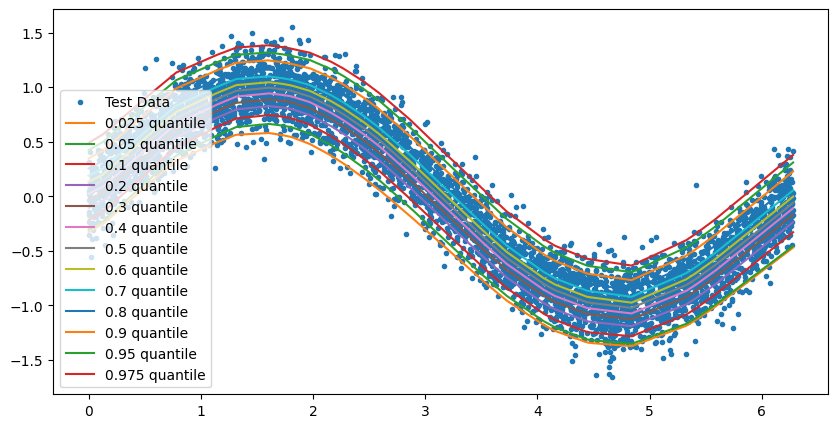

In [16]:
sort_indices=np.argsort(X_test[:,0])
X_test_sort=X_test[sort_indices]
y_test_sort=y_test[sort_indices]
preds = model.predict(X_test_sort)

plt.plot(X_test_sort,y_test_sort,'.')
plt.plot(X_test_sort,preds)

legend=["Test Data"]
quantiles_str=[str(quant)+" quantile" for quant in quantiles]
legend.extend(quantiles_str)
plt.legend(legend)
plt.show()

In [17]:
QuantileNetwork.quant_rate(y_test_sort,preds)

array([0.0248, 0.0422, 0.0902, 0.1842, 0.2922, 0.3978, 0.4986, 0.6094,
       0.7096, 0.8136, 0.9152, 0.9598, 0.982 ])

In [18]:
def cdf(pred, x, quantiles):
    r"""
    Approximate the posterior CDF for given inputs x.

    Propagates the inputs in x forward through the network and
    approximates the posterior CDF by a piecewise linear function.

    The piecewise linear function is given by its values at approximate
    quantiles :math:`x_\tau`` for :math:`\tau = \{0.0, \tau_1, \ldots,
    \tau_k, 1.0\}` where :math:`\tau_k` are the quantiles to be estimated
    by the network. The values for :math:`x_{0.0}` and :math:`x_{1.0}` are
    computed using

    .. math::

        x_{0.0} = 2.0 x_{\tau_1} - x_{\tau_2}

        x_{1.0} = 2.0 x_{\tau_k} - x_{\tau_{k-1}}

    Arguments:

        x(np.array): Array of shape (n, m) containing n inputs for which
                        to predict the conditional quantiles.

    Returns:

        Tuple (xs, fs) containing the :math:`x`-values in xs and corresponding
        values of the posterior CDF :math:`F(x)` in fs.

    """
    if len(x.shape) > 1:
        s = x.shape[:-1] + (len(quantiles) + 2,)
    else:
        s = (1, len(quantiles) + 2)

    y_pred = np.zeros(s)
    y_pred[:, 1:-1] = pred
    y_pred[:, 0] = 2.0 * y_pred[:, 1] - y_pred[:, 2]
    y_pred[:, -1] = 2.0 * y_pred[:, -2] - y_pred[:, -3]

    qs = np.zeros(len(quantiles) + 2)
    qs[1:-1] = quantiles
    qs[0] = 0.0
    qs[-1] = 1.0

    return y_pred, qs

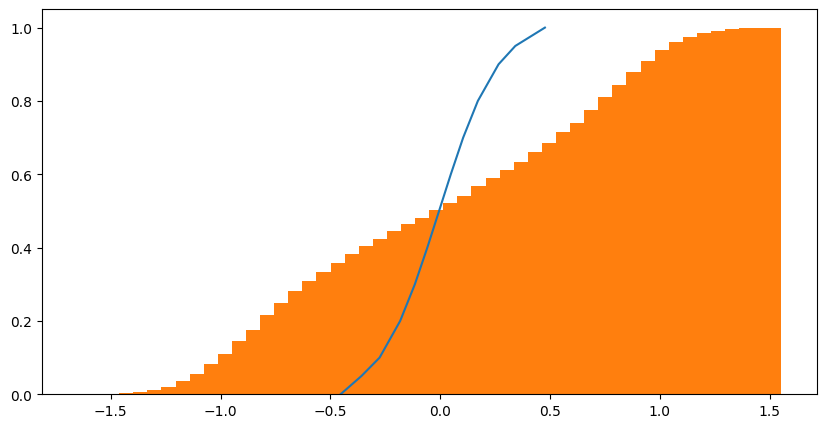

In [19]:
x_cdf, y_cdf = cdf(preds,X_test_sort,quantiles)

plt.plot(np.mean(x_cdf,axis=0),y_cdf)
plt.hist(y_test,cumulative=True, density=True,bins=50)
plt.show()

In [52]:
index_median=6
example_cdf_ix=1
b=4

In [53]:
m=np.abs(preds[:,index_median]-y_test[:])
m_isort=np.argsort(m)
pred_y_post_s=preds[m_isort,:]
y_post_s=y_test[m_isort]
X_post_s=X_test[m_isort]

In [54]:
example_cdf=pred_y_post_s[example_cdf_ix,:]
example_cdf_01=np.zeros(len(quantiles_01))
example_cdf_01[1:-1]=example_cdf
example_cdf_01[-1]=2.0 * example_cdf[-1] -example_cdf[-2]
example_cdf_01[0]= 2.0 * example_cdf[0] -example_cdf[1]
    

example_pdf=(quantiles_01[1:]-quantiles_01[:-1])/(example_cdf_01[1:]-example_cdf_01[:-1])
example_pdf_x=(example_cdf_01[1:]+example_cdf_01[:-1])/2
example_pdf_x_extra=np.zeros(len(example_pdf_x)+2)

example_pdf_x_extra[1:-1]=example_pdf_x
example_pdf_x_extra[0]=example_pdf_x[0]
example_pdf_x_extra[-1]=example_pdf_x[-1]

example_pdf_extra=np.zeros(len(example_pdf)+2)
example_pdf_extra[1:-1]=example_pdf
example_pdf_extra[0]=0
example_pdf_extra[-1]=0

(-0.5845000624656678, 0.5097145915031434)

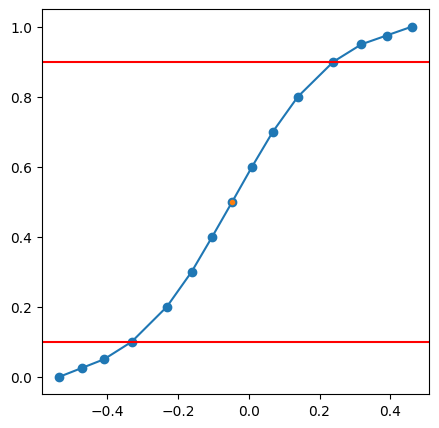

In [61]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.plot(example_cdf_01,quantiles_01,'-o')
plt.plot(y_post_s[example_cdf_ix],0.5,'.')
plt.hlines(0.1,xmin=-1,xmax=1,colors='r')
plt.hlines(0.9,xmin=-1,xmax=1,colors='r')
plt.xlim(np.min(example_cdf_01)-0.05,np.max(example_cdf_01)+0.05)

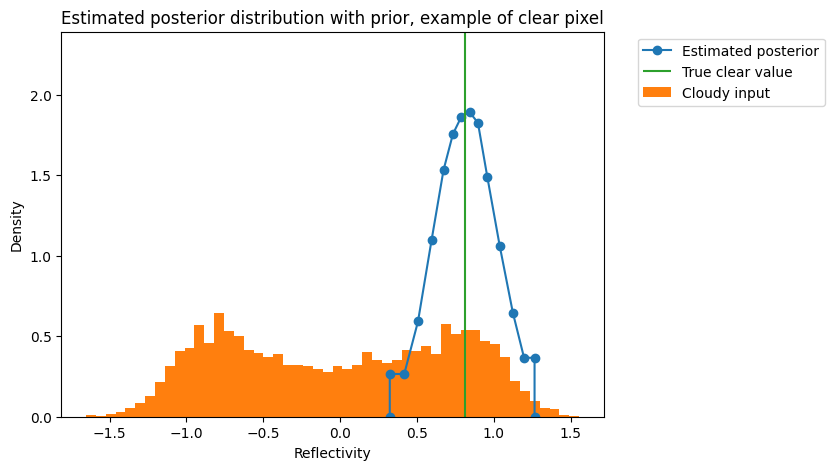

In [51]:
plt.rcParams["figure.figsize"] = [7, 5]
plt.plot(example_pdf_x_extra,example_pdf_extra,'-o')
plt.hist(y_test,density=True,bins=50)
plt.vlines(y_post_s[example_cdf_ix],ymin=0,ymax=np.max(example_pdf)+10,colors='tab:green')
#plt.vlines(X_post_s[example_cdf_ix],ymin=0,ymax=np.max(example_pdf)+10,colors='tab:pink')
plt.ylim([0,np.max(example_pdf)+0.5])
plt.legend(['Estimated posterior','True clear value','Cloudy input','Prior distribution'],bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('Estimated posterior distribution with prior, example of clear pixel')
plt.ylabel('Density')
plt.xlabel('Reflectivity')
plt.show()